In [285]:
import scanpy as sc
import pandas as pd
import numpy as np

#import math #計算combinations
import random #做隨機抽樣分布

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm


from tqdm import tqdm

In [286]:
healthy = sc.read_h5ad("GSE165080_GSE149689_GSE227991_bbknn_database.h5ad")
healthy

AnnData object with n_obs × n_vars = 95261 × 10619
    obs: 'Age', 'Gender', 'BioSample', 'n_genes', 'cell_type_l1', 'cell_type_l2', 'cell_type_l3', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Database'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'BioSample_colors', 'Database_colors', 'cell_type_l1_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [287]:
healthy = healthy[:,healthy.var[healthy.var.highly_variable == True].index]
healthy

View of AnnData object with n_obs × n_vars = 95261 × 2000
    obs: 'Age', 'Gender', 'BioSample', 'n_genes', 'cell_type_l1', 'cell_type_l2', 'cell_type_l3', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Database'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'BioSample_colors', 'Database_colors', 'cell_type_l1_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [288]:
cell_type = list(set(healthy.obs.cell_type_l1))
cell_type

['B', 'DC', 'CD8 T', 'CD4 T', 'Mono', 'other T', 'other', 'NK']

C:\ProgramData\anaconda3\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\ProgramData\anaconda3\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\ProgramData\anaconda3\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

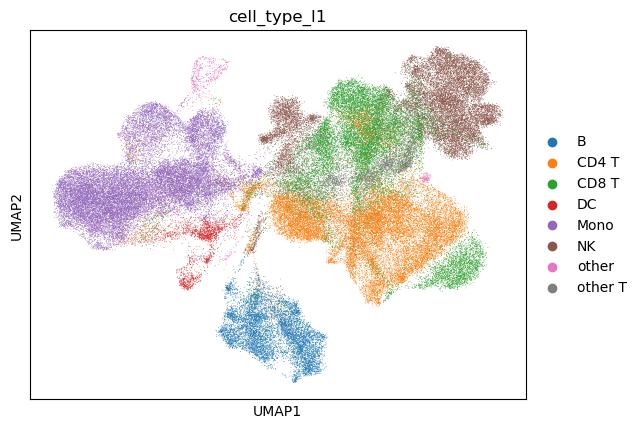

In [325]:
sc.tl.umap(healthy)
sc.pl.umap(healthy, color = "cell_type_l1", show=False)
plt.savefig('./Result_picture/Merge_data/UMAP_GSE165080_GSE149689_GSE227991_bbknn_database(cell_type).png', dpi=300, bbox_inches='tight')

C:\ProgramData\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


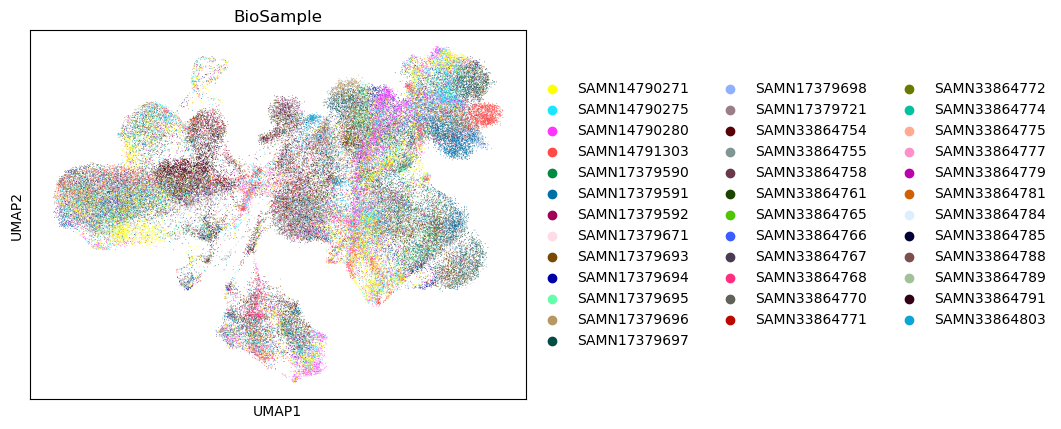

In [326]:
sc.pl.umap(healthy, color = "BioSample")

C:\ProgramData\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


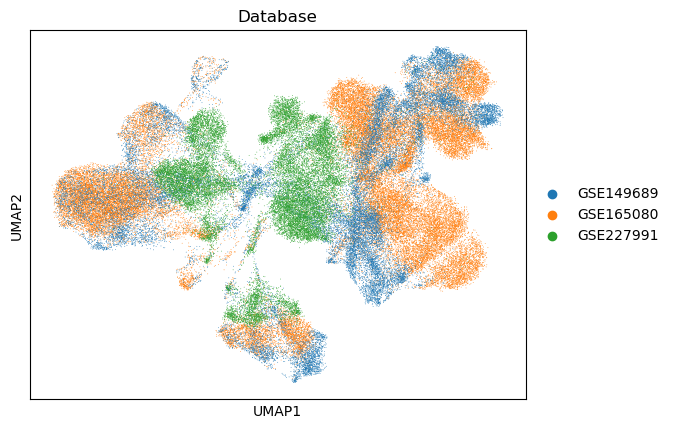

In [327]:
sc.pl.umap(healthy, color = "Database")

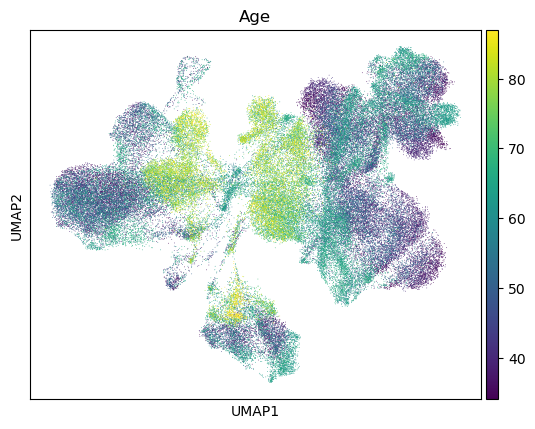

In [328]:
sc.pl.umap(healthy, color = "Age", show=False)
plt.savefig('./Result_picture/Merge_data/UMAP_GSE165080_GSE149689_GSE227991_bbknn_database.png', dpi=300, bbox_inches='tight')

# 將細胞數量過少的移除
#### 總細胞數 < 0.5% remove
#### 總cell type數 < 0.5% remove

In [ ]:
sample = list(set(healthy.obs.BioSample))

rows_to_remove = []
for i in sample:
    if healthy[healthy.obs.BioSample == i,:].n_obs < healthy.n_obs*0.005:
        rows_to_remove.append(i)
healthy_filter = healthy[~healthy.obs.BioSample.isin(rows_to_remove),:]    
    
print(healthy_filter)

# 開始處理cell dispersion

我需要先把每個人的部分個別提取出來，最後再將每個人的NK提取出來做cell dispersion

In [293]:
sample = list(set(healthy.obs.BioSample))

personal = {}
for i in sample:
    if i not in personal:
        personal[i] = healthy[healthy.obs.BioSample == i, :]
len(personal)

37

In [294]:
# 將personal進行排序
sorted_personal = dict(sorted(personal.items(), key=lambda x: x[1].obs.Age[0]))

a = []
for i in sorted_personal:
    if sorted_personal[i][sorted_personal[i].obs.cell_type_l1 == "DC",:].n_obs <= 4:
        a.append(i)
        print(i)
for i in a:
    del sorted_personal[i]
    print(i,"\t Delect")

SAMN33864779
SAMN33864779 	 Delect


In [295]:

# 排序之後取得年齡
age = []
for i in sorted_personal:
    age.append(sorted_personal[i].obs.Age[0])

In [296]:
sorted_personal['SAMN33864789'].obs

,Age,Gender,BioSample,n_genes,cell_type_l1,cell_type_l2,cell_type_l3,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,Database
AAACCTGAGGACAGCT-1,82,male,SAMN33864789,202,CD8 T,CD8 TEM,CD8 TEM_4,201,659.0,0.0,0.000000,10,GSE227991
AAACCTGCACCGATAT-1,82,male,SAMN33864789,234,CD8 T,CD8 TEM,CD8 TEM_2,234,671.0,0.0,0.000000,10,GSE227991
AAACCTGGTATAGGTA-1,82,male,SAMN33864789,283,Mono,CD14 Mono,CD14 Mono,282,1026.0,0.0,0.000000,7,GSE227991
AAACCTGGTCGCCATG-1,82,male,SAMN33864789,250,DC,pDC,pDC,249,805.0,1.0,0.124224,42,GSE227991
AAAGCAAAGTGCCAGA-1,82,male,SAMN33864789,362,Mono,CD14 Mono,CD14 Mono,362,1838.0,1.0,0.054407,27,GSE227991
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCAGGTGATAT-1,82,male,SAMN33864789,219,CD8 T,CD8 TEM,CD8 TEM_4,218,740.0,0.0,0.000000,10,GSE227991
TTTGGTTCAATTGCTG-1,82,male,SAMN33864789,243,CD8 T,CD8 TEM,CD8 TEM_5,243,730.0,0.0,0.000000,10,GSE227991
TTTGGTTTCACATAGC-1,82,male,SAMN33864789,283,Mono,CD14 Mono,CD14 Mono,283,940.0,0.0,0.000000,7,GSE227991
TTTGGTTTCATCGATG-1,82,male,SAMN33864789,220,CD8 T,CD8 TEM,CD8 TEM_2,220,642.0,0.0,0.000000,10,GSE227991


# Cell Dispersion Calculate

In [297]:
# 將30~50個不同的cell放入新的dataframe中，以便後續進行計算
def renew_sampling_list(cell_type, minimum):
    # 隨機抽樣，抽取50個不同的cell之後要做cell dispersion的計算
    sampling = []
    for i in range(0, int(min(1/2*minimum,50))):
        # 挑出cell的位置
        cell = random.randrange(0, cell_type.n_obs)
        while cell in sampling:
            cell = random.randrange(0, cell_type.n_obs)
        sampling.append(cell)

    # 紀錄50個cell * gene的資料
    cell_dispersion = []
    # 先將 cell type 變成dataframe後，做 transpose 之後才能夠把挑選出來的 genes 放進去
    cell_type_transpose = pd.DataFrame(data = cell_type.X, columns = cell_type.var.index.values)
    # 做50次的隨機抽樣並且將結果
    for i in range(0, int(min(1/2*minimum, 50))):
        # 將dataframe塞進去新的list中
        cell_dispersion.append(cell_type_transpose.loc[sampling[i]])
    #將list轉成dataframe的格式
    cell_dispersion = np.array(cell_dispersion)

    return cell_dispersion

# 將某一個人的 cell type 提取出來做cell dispersion, 之後再拿其他人的去做比較
# 要給numpy array的格式
def create_distance_matrix(data):
    # must be two dimension array, so need to change dataframe into array
    ncells = data.shape[0]

    # matric 會是aaabbbccc
    index1 = np.concatenate(tuple(np.repeat(i, ncells) for i in range(0,ncells)), axis =None)
    # matirc 會是abcabcabc
    index2 = np.tile(np.arange(0, ncells, 1), ncells)

    X = data[:, index1]
    Y = data[:, index2]

    # Euclidean Distance
    out = np.sqrt(np.sum((X - Y) * (X - Y), axis = 0))

    distance_matrix = np.reshape(out, (ncells, ncells))

    return distance_matrix

# 計算離散程度，將n*n計算過後的matrix丟進來
def calculate_dispersion(distance):
    # np.triu只取上三角，其餘的都變成0
    # np.count_nonzero 計算非0的部分有多少個
    dispersion = np.triu(distance).sum()/np.count_nonzero(np.triu(distance))
    return dispersion


# 將上面的所有的function合併成這個function執行
def Excute_all(sorted_personal, cell_type_name):# cell_type_name是字串的型態

    pbar = tqdm(total = len(sorted_personal))

    dispersion_personal = []
    mean = []
    distance = []
    # 總共人數
    for i in sorted_personal:
        # Data augmentation for 10 times
        # 挑出最小值
        minimum = 50
        # 取得所需的cell type 以及 random select 80% anndata
        #random_select_anndata = data_sampling_size(sorted_personal[i][sorted_personal[i].obs.cell_type_l1 == cell_type_name, :], select_size = 0.8)
        
        a = sorted_personal[i][sorted_personal[i].obs.cell_type_l1 == cell_type_name, :].obs
        cell_type = sorted_personal[i][sorted_personal[i].obs.cell_type_l1 == cell_type_name, :]
        if len(a) < minimum:
            minimum = len(a)

        dispersion = []
        # 1000 times sampling
        for j in range(0,1000):
            # 取得sampling的dataframe
            cell_dispersion = renew_sampling_list(cell_type, minimum)
            # 計算 cell * cell distance
            distance_matrix = create_distance_matrix(cell_dispersion)
            # 取得此次抽樣的dispersion
            dispersion.append(calculate_dispersion(distance_matrix))


        distance.append(distance_matrix)

        dispersion_personal.append(dispersion)
        mean.append(np.mean(dispersion))

        pbar.update()
    pbar.close()

    # 計算標準差
    count = 0
    std = [] # 每一個人的標準差
    for i in range(len(distance)):
        count = (distance[i]-mean[i]) * (distance[i]-mean[i])
        std.append(np.sqrt(np.sum(count)/(len(distance)*((len(distance[i])*(len(distance[i])-1))/2)-1)))


    return dispersion_personal, mean, std

# 結果畫圖

In [298]:
def scatter_plot(data, title, cell_type, sorted_personal):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(len(sorted_personal)):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = int(float(age[i]))
        y = data[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.scatter(x, y, color = cmap(i))

    # 給圖表加上標題和軸標籤
    plt.title(title)
    
    # 這將 x 軸的刻度標籤大小設置為 8
    plt.tick_params(axis='x', labelsize=8)  
    # 這將 x 軸的刻度標籤旋轉 60 度
    plt.xticks(rotation = 60)  
    
    plt.xlabel('Age', fontsize = 14)
    plt.ylabel('Value', fontsize = 14)

    # 添加圖例
    plt.legend(age, fontsize = 6, bbox_to_anchor = (1.05, 1), loc = 'upper left', ncol = 1)
    
    # 將圖形保存為PNG文件
    #plt.savefig(f'Result_picture/GSE174188/Cell dispersion/Scatter_plot_{cell_type}.png', dpi=900)

    
    
    # 顯示圖表
    plt.show()
    

def errorbar(mean, std, title, cell_type, sorted_personal):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(len(sorted_personal)):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = int(float(age[i]))
        y = mean[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.errorbar(x, y, yerr = std[i], color = cmap(i), fmt = 'o')

    # 這將 x 軸的刻度標籤大小設置為 8
    plt.tick_params(axis='x', labelsize=8)  
    # 這將 x 軸的刻度標籤旋轉 60 度
    plt.xticks(rotation = 60)
        
    # 計算趨勢線的參數
    z = np.polyfit([int(float(a)) for a in age], mean, 1)
    # 創建一個多項式函數
    p = np.poly1d(z)
    print("斜率 :",p)
    test = list(set([int(float(a)) for a in age]))
    # 在圖中添加趨勢線
    plt.plot(test, p(test), 'r--', label='Trend Line')
    
    
    # 給圖表加上標題和軸標籤
    plt.title(title, fontsize = 16)
    plt.xlabel('Age', fontsize = 14)
    plt.ylabel('Dispersion', fontsize = 14)

    # 添加圖例
    plt.legend(["Trand Line"] + age, fontsize = 6, bbox_to_anchor=(1.05, 1), loc='upper left', ncol = 1)
    
    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/Merge_data/Cell dispersion/Cell Dispersion_{cell_type}_GSE165080_GSE149689_GSE227991_bbknn_database.png', dpi=300, bbox_inches='tight')

    # 顯示圖表
    plt.show()
    
def distribution(mean, std, age, cell_type):
    for i in range(0, len(mean)):
        x = np.arange(-4, 10, 0.001)
        y = norm.pdf(x, mean[i], std[i])
        plt.plot(x,y)
    
    # 添加圖例
    plt.legend(age, fontsize = 8, bbox_to_anchor = (1.05, 1), loc = 'upper left', ncol = 1)
    # 添加標題和軸標籤
    plt.title(f"{cell_type} cell dispersion", fontsize = 16)
    plt.xlabel('Different Sample', fontsize = 14)
    plt.ylabel('Probability Density', fontsize = 14)


    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/Merge_data/Cell dispersion/{cell_type} cell dispersion_GSE165080_GSE149689_GSE227991_bbknn_database.png', dpi=300, bbox_inches='tight')

In [299]:
cell_type

['B', 'DC', 'CD8 T', 'CD4 T', 'Mono', 'other T', 'other', 'NK']

# NK cell dispersion

In [300]:
dispersion_personal_NK, mean_NK, std_NK = Excute_all(sorted_personal, "NK")

100%|██████████| 36/36 [01:38<00:00,  2.74s/it]


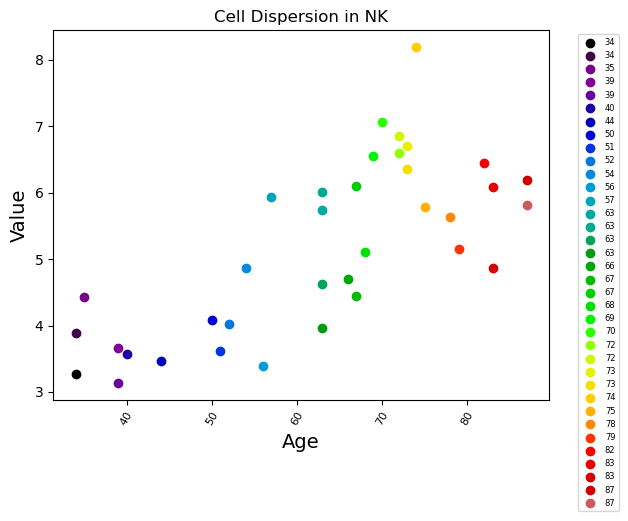

In [301]:
scatter_plot(mean_NK, "Cell Dispersion in NK", "NK", sorted_personal)

斜率 :  
0.06032 x + 1.386


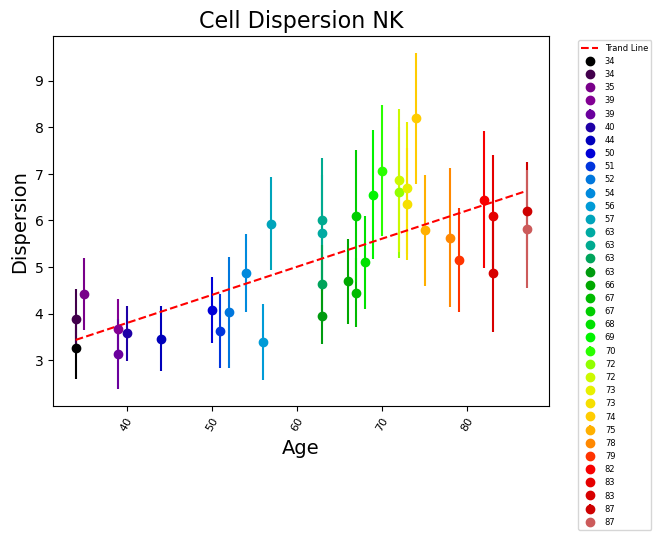

In [302]:
errorbar(mean_NK, std_NK, "Cell Dispersion NK", "NK", sorted_personal)

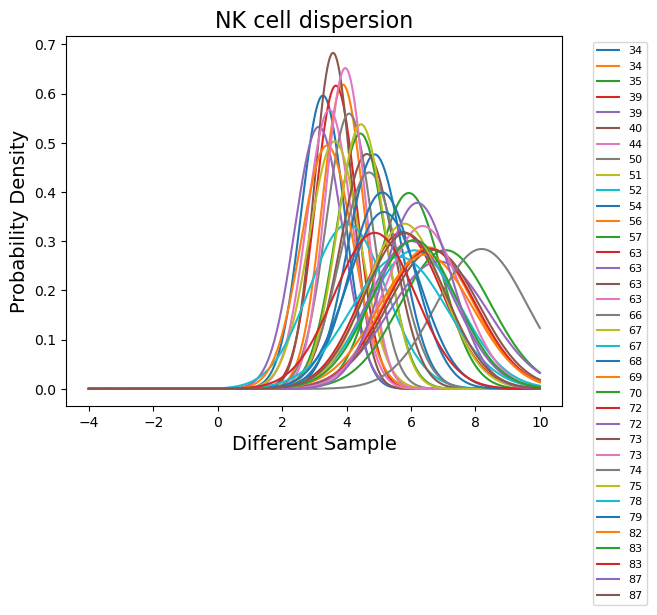

In [303]:
distribution(mean_NK, std_NK, age, "NK")

# Monocyte cell dispersion

In [304]:
dispersion_personal_Monocyte, mean_Monocyte, std_Monocyte = Excute_all(sorted_personal, "Mono")

100%|██████████| 36/36 [02:24<00:00,  4.00s/it]


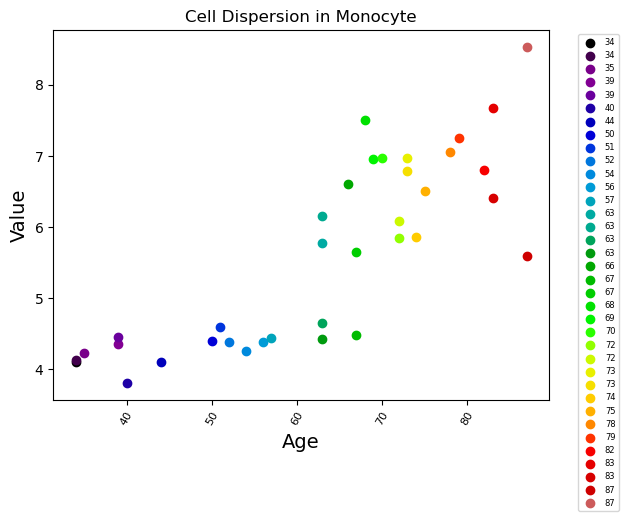

In [305]:
scatter_plot(mean_Monocyte, "Cell Dispersion in Monocyte", "Monocyte", sorted_personal)

斜率 :  
0.06812 x + 1.339


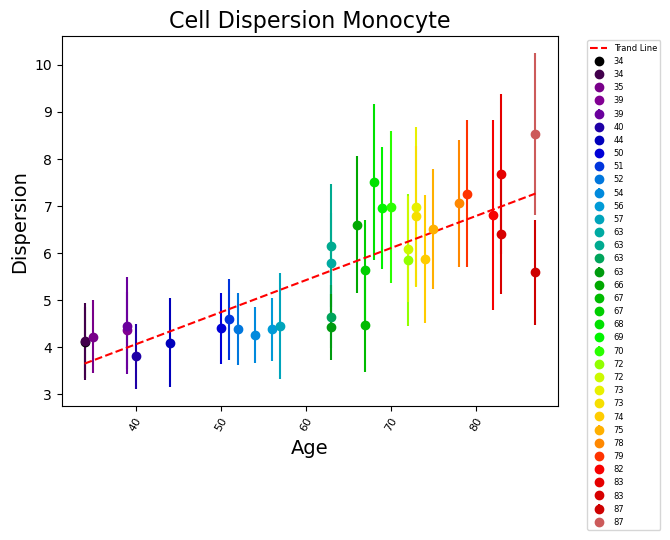

In [306]:
errorbar(mean_Monocyte, std_Monocyte, "Cell Dispersion Monocyte", "Monocyte", sorted_personal)

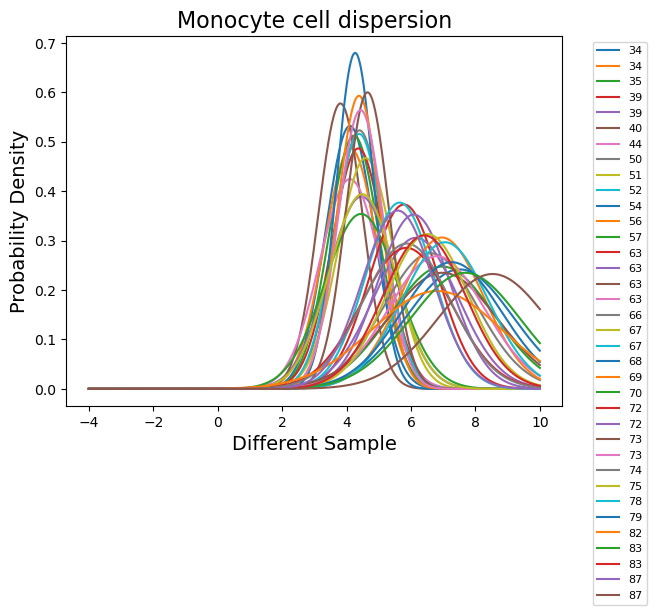

In [307]:
distribution(mean_Monocyte, std_Monocyte, age, "Monocyte")

# CD4 T cell dispersion

In [308]:
dispersion_personal_CD4T, mean_CD4T, std_CD4T = Excute_all(sorted_personal, "CD4 T")

100%|██████████| 36/36 [02:05<00:00,  3.48s/it]


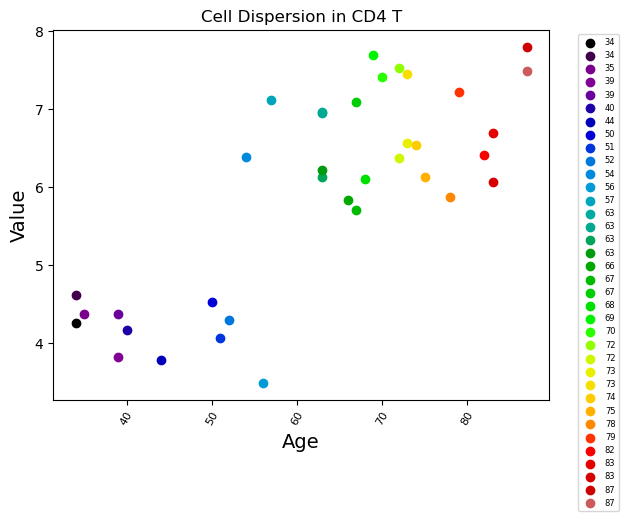

In [309]:
scatter_plot(mean_CD4T, "Cell Dispersion in CD4 T", "CD4 T", sorted_personal)

斜率 :  
0.06548 x + 1.818


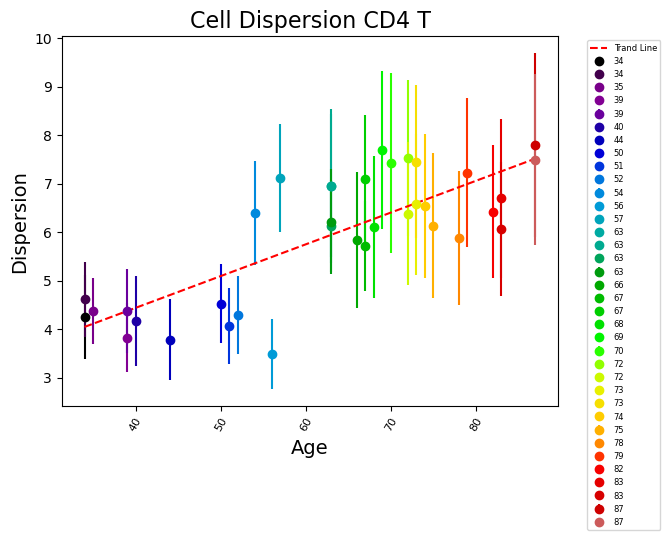

In [310]:
errorbar(mean_CD4T, std_CD4T, "Cell Dispersion CD4 T", "CD4 T", sorted_personal)

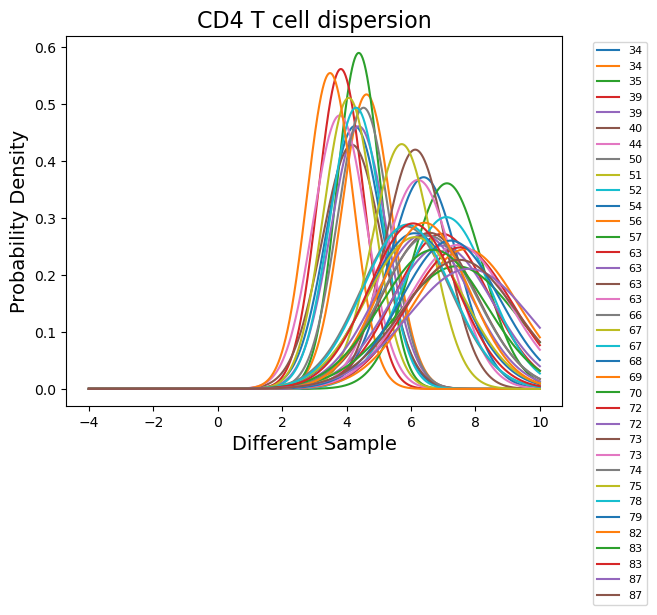

In [311]:
distribution(mean_CD4T, std_CD4T, age, "CD4 T")

# CD8 T cell dispersion

In [312]:
dispersion_personal_CD8T, mean_CD8T, std_CD8T = Excute_all(sorted_personal, "CD8 T")

100%|██████████| 36/36 [01:54<00:00,  3.18s/it]


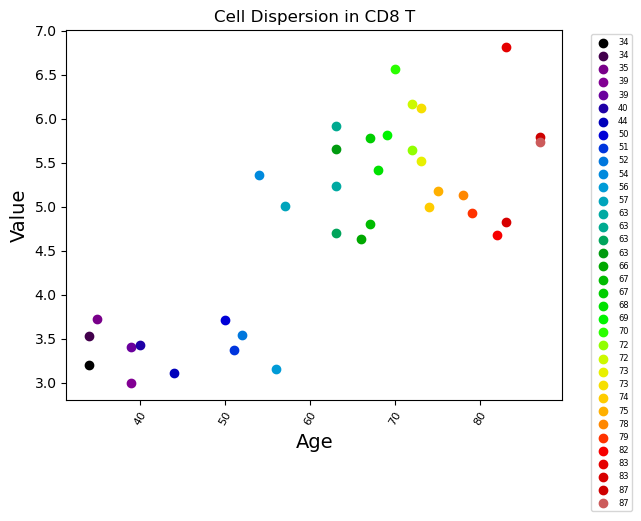

In [313]:
scatter_plot(mean_CD8T, "Cell Dispersion in CD8 T", "CD8 T", sorted_personal)

斜率 :  
0.05387 x + 1.439


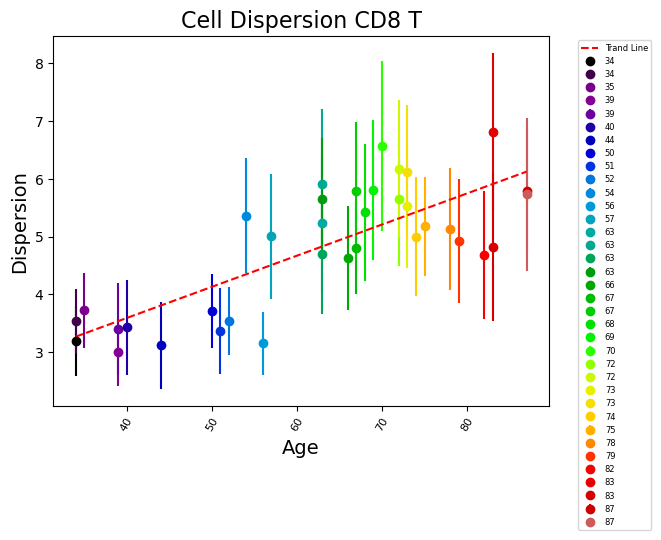

In [314]:
errorbar(mean_CD8T, std_CD8T, "Cell Dispersion CD8 T", "CD8 T", sorted_personal)

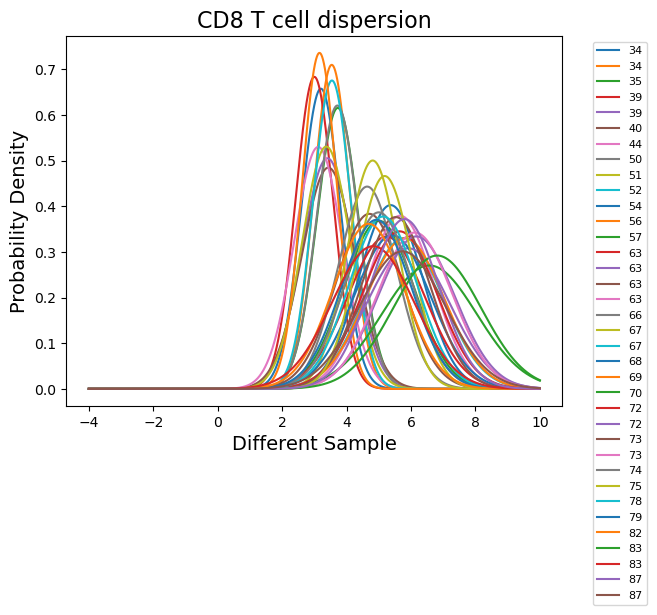

In [315]:
distribution(mean_CD8T, std_CD8T, age, "CD8 T")

# B cell dispersion

In [316]:
dispersion_personal_B, mean_B, std_B = Excute_all(sorted_personal, "B")

100%|██████████| 36/36 [00:57<00:00,  1.60s/it]


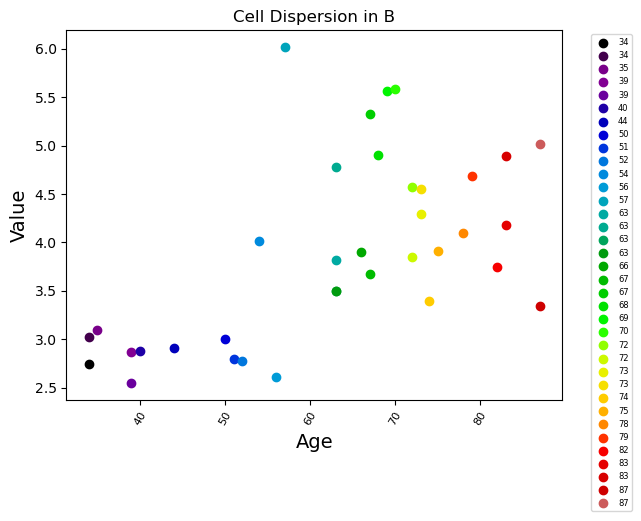

In [317]:
scatter_plot(mean_B, "Cell Dispersion in B", "B", sorted_personal)

斜率 :  
0.03536 x + 1.677


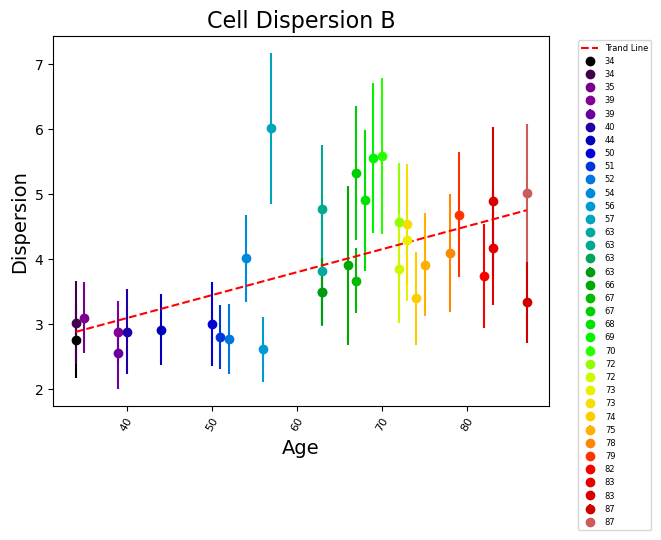

In [318]:
errorbar(mean_B, std_B, "Cell Dispersion B", "B", sorted_personal)

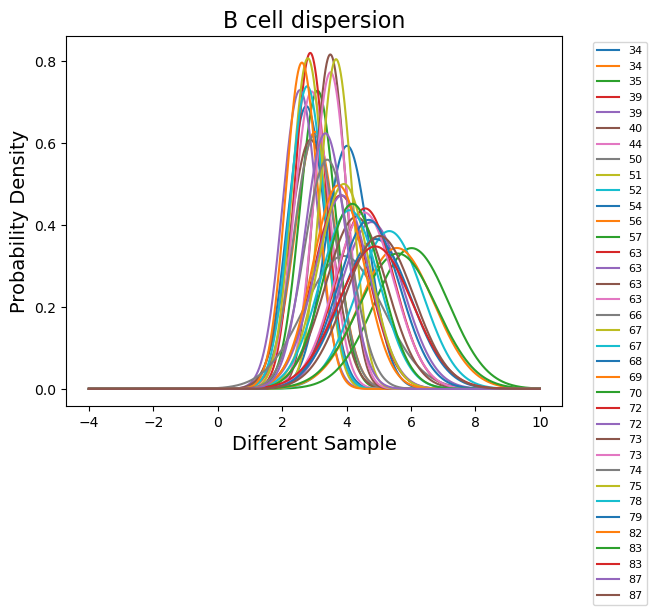

In [319]:
distribution(mean_B, std_B, age, "B")

# DC cell dispersion

In [320]:
dispersion_personal_DC, mean_DC, std_DC = Excute_all(sorted_personal, "DC")

100%|██████████| 36/36 [00:23<00:00,  1.54it/s]


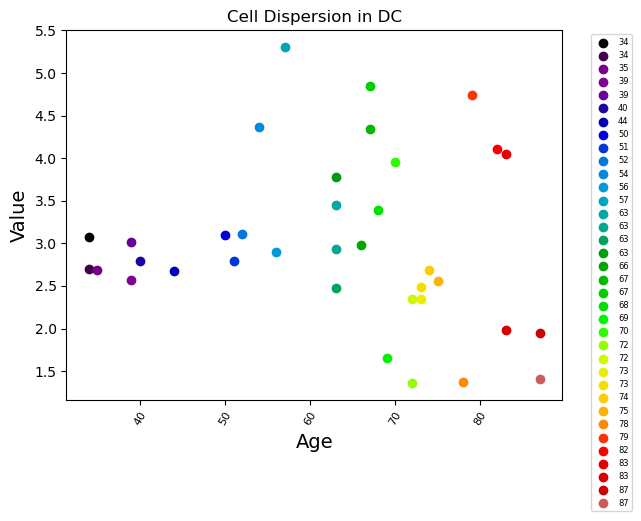

In [321]:
scatter_plot(mean_DC, "Cell Dispersion in DC", "DC", sorted_personal)

斜率 :  
-0.006304 x + 3.405


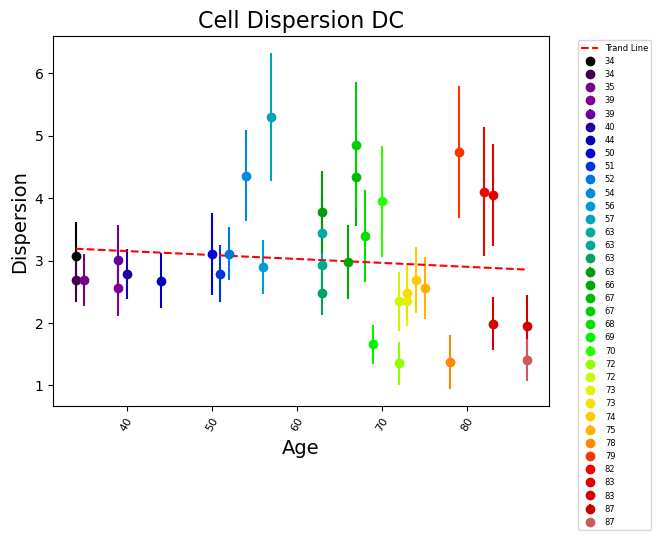

In [322]:
errorbar(mean_DC, std_DC, "Cell Dispersion DC", "DC", sorted_personal)

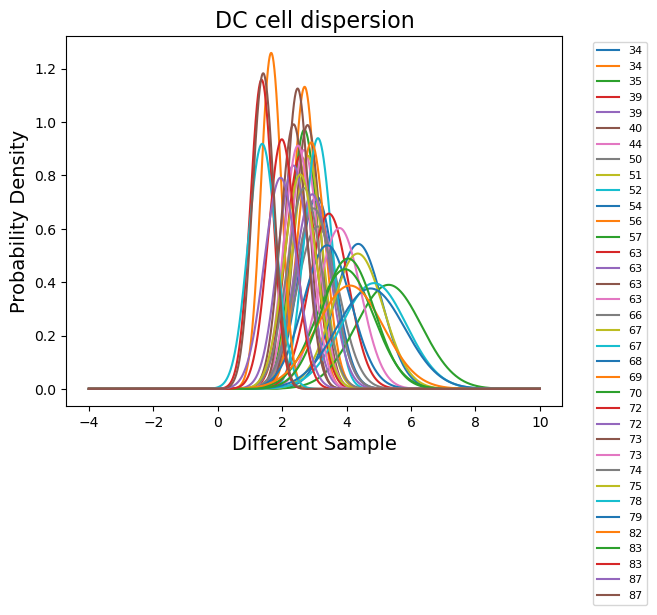

In [323]:
distribution(mean_DC, std_DC, age, "DC")

# Mean & Std寫檔

In [324]:
import csv
with open('mean_and_stdev_GSE165080_GSE149689_GSE227991_bbknn_database.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    # 寫入列名
    writer.writerow([''] + ['age', 'mean_NK', 'mean_CD4T', 'mean_CD8T', 'mean_B', 'mean_Monocyte', 'mean_DC', 'std_NK', 'std_CD4T', 'std_CD8T', 'std_B', 'std_Monocyte', 'std_DC'])    
    # 寫入數據
    for sample, Age, Mean_NK, Mean_CD4T, Mean_CD8T, Mean_B, Mean_Monocyte, Mean_DC, Std_NK, Std_CD4T, Std_CD8T, Std_B, Std_Monocyte, Std_DC in zip(sorted_personal, age, mean_NK, mean_CD4T, mean_CD8T, mean_B, mean_Monocyte, mean_DC, std_NK, std_CD4T, std_CD8T, std_B, std_Monocyte, std_DC):
        writer.writerow([sample] + [Age, Mean_NK, Mean_CD4T, Mean_CD8T, Mean_B, Mean_Monocyte, Mean_DC, Std_NK, Std_CD4T, Std_CD8T, Std_B, Std_Monocyte, Std_DC])

In [240]:
with open("Merge_data/SraRunTable_GSE227991.txt", 'r') as file:
    sra = pd.read_csv(file, index_col = 0)

In [241]:
for i in sra["BioSample"]:
    healthy.obs.loc[healthy.obs.BioSample == i, "Database"] = "GSE227991"

In [242]:
#healthy.obs["Database"]= [None] * healthy.obs.shape[0]
healthy.obs

,Age,Gender,BioSample,n_genes,cell_type_l1,cell_type_l2,cell_type_l3,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,Database
AAACCTGAGAGTTGGC-1,34,female,SAMN17379694,3734,Mono,CD14 Mono,CD14 Mono,3516,11692.0,529.0,4.524461,0,GSE165080
AAACCTGAGGGCTTGA-1,34,female,SAMN17379694,2001,other T,gdT,gdT_1,1894,4628.0,338.0,7.303370,28,GSE165080
AAACCTGCAAGCTGTT-1,34,female,SAMN17379694,2471,CD8 T,CD8 Naive,CD8 Naive,2312,7806.0,384.0,4.919293,12,GSE165080
AAACCTGCAATAAGCA-1,34,female,SAMN17379694,1487,NK,NK,NK_1,1412,2778.0,371.0,13.354932,5,GSE165080
AAACCTGCAATGTAAG-1,34,female,SAMN17379694,2423,CD8 T,CD8 TCM,CD8 TCM_1,2298,6596.0,550.0,8.338387,12,GSE165080
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGGTGCACA-1-1,66,male,SAMN33864803,293,Mono,CD14 Mono,CD14 Mono,293,1149.0,0.0,0.000000,7,GSE227991
TTTGGTTAGGTTACCT-1,66,male,SAMN33864803,304,NK,NK,NK_4,304,898.0,2.0,0.222717,11,GSE227991
TTTGGTTCAGCATACT-1,66,male,SAMN33864803,263,NK,NK,NK_1,263,856.0,1.0,0.116822,10,GSE227991
TTTGTCAAGGAGCGAG-1,66,male,SAMN33864803,228,NK,NK,NK_1,228,644.0,0.0,0.000000,10,GSE227991


In [195]:
healthy.obs

,Age,Gender,BioSample,n_genes,cell_type_l1,cell_type_l2,cell_type_l3,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACCTGAGAGTTGGC-1,34,female,SAMN17379694,3734,Mono,CD14 Mono,CD14 Mono,3516,11692.0,529.0,4.524461,0
AAACCTGAGGGCTTGA-1,34,female,SAMN17379694,2001,other T,gdT,gdT_1,1894,4628.0,338.0,7.303370,28
AAACCTGCAAGCTGTT-1,34,female,SAMN17379694,2471,CD8 T,CD8 Naive,CD8 Naive,2312,7806.0,384.0,4.919293,12
AAACCTGCAATAAGCA-1,34,female,SAMN17379694,1487,NK,NK,NK_1,1412,2778.0,371.0,13.354932,5
AAACCTGCAATGTAAG-1,34,female,SAMN17379694,2423,CD8 T,CD8 TCM,CD8 TCM_1,2298,6596.0,550.0,8.338387,12
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGGTGCACA-1-1,66,male,SAMN33864803,293,Mono,CD14 Mono,CD14 Mono,293,1149.0,0.0,0.000000,7
TTTGGTTAGGTTACCT-1,66,male,SAMN33864803,304,NK,NK,NK_4,304,898.0,2.0,0.222717,11
TTTGGTTCAGCATACT-1,66,male,SAMN33864803,263,NK,NK,NK_1,263,856.0,1.0,0.116822,10
TTTGTCAAGGAGCGAG-1,66,male,SAMN33864803,228,NK,NK,NK_1,228,644.0,0.0,0.000000,10
